In [30]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.python.keras.layers import Dense
from numpy.random import default_rng
from sklearn.model_selection import train_test_split

In [31]:
# Loading pipeline params.
DATA_PATH = Path('data')
FILENAME_STOP = 'stop_90_diff_quat.csv'
FILENAME_0 = '0_90_diff_quat.csv'
FILENAME_90 = '90_90_diff_quat.csv'
FILENAME_180 = '180_90_diff_quat.csv'
FILENAME_270 = '270_90_diff_quat.csv'

NUM_TIMESTEPS = 6
IGNORE_FRACTION = 0.1
TEST_FRACTION = 0.25

# Training params.
LEARNING_RATE = 1e-5
EPOCHS = 100
BATCH_SIZE = 512

In [32]:
def load_data(
    path_stop,
    path_0,
    path_90,
    path_180,
    path_270,
    num_timesteps,
    ignore_fraction,
    test_fraction,
):

    def read_and_prepare_data(
        path,
        class_,
        num_timesteps,
        ignore_fraction,
        test_fraction,
    ):

        def split_temporally(X, test_fraction):
            num_samples = X.shape[0]
            num_train = int(num_samples * (1.0 - test_fraction))
            X_train, X_test = X[:num_train], X[num_train:]
            return X_train, X_test

        def transform_into_sequences(X, num_timesteps):
            num_samples = X.shape[0]
            X_seq = []
            for k in range(num_samples - num_timesteps + 1):
                X_seq.append(X[k:(k + num_timesteps)])
            X_seq = np.array(X_seq)
            y_seq = class_ * np.ones((X_seq.shape[0], 1))
            return X_seq, y_seq

        X = pd.read_csv(path).values
        X = X[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13]]

        # Ignore beginning and end.
        num_samples = X.shape[0]
        num_ignore = int(ignore_fraction * num_samples)
        X = X[num_ignore:-num_ignore]

        # Split X temporally.
        X_train, X_test = split_temporally(X, test_fraction)
        
        # Transform X into short sequences.
        X_train, y_train = transform_into_sequences(X_train, num_timesteps)
        X_test, y_test = transform_into_sequences(X_test, num_timesteps)
        X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
        return X_train, y_train, X_test, y_test, X_val, y_val

    def shuffle_data(X, y):
        idx = np.arange(len(X))
        default_rng().shuffle(idx)
        X_shuffled = X[idx, :]
        y_shuffled = y[idx]
        return X_shuffled, y_shuffled

    X_train_stop, y_train_stop, X_test_stop, y_test_stop, X_val_stop, y_val_stop = \
        read_and_prepare_data(
            path_stop,
            0.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )
    
    X_train_0, y_train_0, X_test_0, y_test_0, X_val_0, y_val_0 = \
        read_and_prepare_data(
            path_0,
            1.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )

    X_train_90, y_train_90, X_test_90, y_test_90, X_val_90, y_val_90 = \
        read_and_prepare_data(
            path_90,
            2.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )
    
    X_train_180, y_train_180, X_test_180, y_test_180, X_val_180, y_val_180 = \
        read_and_prepare_data(
            path_180,
            3.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )
    
    X_train_270, y_train_270, X_test_270, y_test_270,X_val_270, y_val_270  = \
        read_and_prepare_data(
            path_270,
            4.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )

    X_train = np.concatenate((X_train_stop, X_train_0, X_train_90, X_train_180, X_train_270), axis=0)
    y_train = np.concatenate((y_train_stop, y_train_0, y_train_90, y_train_180, y_train_270), axis=0)
    X_test = np.concatenate((X_test_stop, X_test_0, X_test_90, X_test_180, X_test_270), axis=0)
    y_test = np.concatenate((y_test_stop, y_test_0, y_test_90, y_test_180, y_test_270), axis=0)
    X_val = np.concatenate((X_val_stop, X_val_0, X_val_90, X_val_180, X_val_270), axis=0)
    y_val = np.concatenate((y_val_stop, y_val_0, y_val_90, y_val_180, y_val_270), axis=0)

    
    
    X_train, y_train = shuffle_data(X_train, y_train)
    X_test, y_test = shuffle_data(X_test, y_test)
    X_val, y_val = shuffle_data(X_val, y_val)
    return X_train, X_test,X_val, y_train, y_test, y_val


path_stop = Path(DATA_PATH, FILENAME_STOP)
path_0 = Path(DATA_PATH, FILENAME_0)
path_90 = Path(DATA_PATH, FILENAME_90)
path_180 = Path(DATA_PATH, FILENAME_180)
path_270 = Path(DATA_PATH, FILENAME_270)

X_train, X_test, X_val, y_train, y_test , y_val= load_data(
    path_stop,
    path_0,
    path_90,
    path_180,
    path_270,
    NUM_TIMESTEPS,
    IGNORE_FRACTION,
    TEST_FRACTION,
)

In [33]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((14375, 6, 14), (14375, 1), (2385, 6, 14), (2385, 1))

In [34]:
X_test[60].shape


(6, 14)

In [138]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer

CNN = Sequential(name="Sequential_CNN")

CNN.add(Conv2D(256, kernel_size=(2, 2),
               strides=(4, 4), padding="same",
               activation="selu", input_shape=[6, 14, 1]))

CNN.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1),
                     padding="valid"))

# Add another pair of Conv2D and MaxPooling2D for more model depth,
# followed by the flatten and multiple dense layers

# CNN.add(Conv2D(64, kernel_size=(3, 3),
#                strides=(1, 1), padding="same",
#                activation="selu"))

# CNN.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1),
#                      padding="valid"))
# CNN.add(InputLayer(input_shape=(6,14,1 )))
CNN.add(Flatten(input_shape=(6,14,1 )))
CNN.add(Flatten(input_shape=(6,14,1 )))

CNN.add(Dense(64, activation='selu'))
CNN.add(Dense(32, activation='selu'))
CNN.add(Dense(5, activation='softmax'))

CNN.summary()

Model: "Sequential_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 2, 4, 256)         1280      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 1, 3, 256)        0         
 2D)                                                             
                                                                 
 flatten_19 (Flatten)        (None, 768)               0         
                                                                 
 dense_29 (Dense)            (None, 5)                 3845      
                                                                 
Total params: 5,125
Trainable params: 5,125
Non-trainable params: 0
_________________________________________________________________


In [139]:
from numpy import *
where_are_NaNsx = isnan(X_train)
X_train[where_are_NaNsx] = 0

where_are_NaNsy = isnan(y_train)
y_train[where_are_NaNsy] = 0

where_are_NaNsxt = isnan(X_test)
X_test[where_are_NaNsxt] = 0

where_are_NaNsyt = isnan(y_test)
y_test[where_are_NaNsyt] = 0

In [140]:
optimizer = keras.optimizers.Adam(learning_rate=1e-4)

CNN.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['categorical_accuracy'],
)
history = CNN.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=256,
    validation_data=(X_val, y_val),
    verbose=1,
)

Epoch 1/100
57/57 [==============================] - 1s 9ms/step - loss: 1.5756 - categorical_accuracy: 0.1734 - val_loss: 1.5338 - val_categorical_accuracy: 0.0029
Epoch 2/100
57/57 [==============================] - 1s 10ms/step - loss: 1.4834 - categorical_accuracy: 6.9565e-04 - val_loss: 1.4485 - val_categorical_accuracy: 0.0000e+00
Epoch 3/100
57/57 [==============================] - 0s 8ms/step - loss: 1.3810 - categorical_accuracy: 0.0000e+00 - val_loss: 1.3521 - val_categorical_accuracy: 0.0000e+00
Epoch 4/100
57/57 [==============================] - 0s 8ms/step - loss: 1.2687 - categorical_accuracy: 0.0000e+00 - val_loss: 1.2497 - val_categorical_accuracy: 0.0000e+00
Epoch 5/100
57/57 [==============================] - 0s 8ms/step - loss: 1.1558 - categorical_accuracy: 0.0000e+00 - val_loss: 1.1523 - val_categorical_accuracy: 0.0000e+00
Epoch 6/100
57/57 [==============================] - 0s 8ms/step - loss: 1.0523 - categorical_accuracy: 0.0000e+00 - val_loss: 1.0663 - val_ca

Epoch 50/100
57/57 [==============================] - 0s 7ms/step - loss: 0.4748 - categorical_accuracy: 0.0518 - val_loss: 0.4380 - val_categorical_accuracy: 0.0816
Epoch 51/100
57/57 [==============================] - 0s 8ms/step - loss: 0.4723 - categorical_accuracy: 0.0563 - val_loss: 0.4309 - val_categorical_accuracy: 0.0795
Epoch 52/100
57/57 [==============================] - 0s 7ms/step - loss: 0.4701 - categorical_accuracy: 0.0559 - val_loss: 0.4319 - val_categorical_accuracy: 0.0782
Epoch 53/100
57/57 [==============================] - 0s 8ms/step - loss: 0.4681 - categorical_accuracy: 0.0552 - val_loss: 0.4292 - val_categorical_accuracy: 0.0837
Epoch 54/100
57/57 [==============================] - 0s 8ms/step - loss: 0.4657 - categorical_accuracy: 0.0589 - val_loss: 0.4312 - val_categorical_accuracy: 0.0816
Epoch 55/100
57/57 [==============================] - 0s 8ms/step - loss: 0.4637 - categorical_accuracy: 0.0583 - val_loss: 0.4297 - val_categorical_accuracy: 0.0845
Epoc

57/57 [==============================] - 0s 8ms/step - loss: 0.3952 - categorical_accuracy: 0.0817 - val_loss: 0.3638 - val_categorical_accuracy: 0.1130
Epoch 100/100
57/57 [==============================] - 0s 7ms/step - loss: 0.3939 - categorical_accuracy: 0.0827 - val_loss: 0.3603 - val_categorical_accuracy: 0.1130


In [145]:
# from functools import partial



# _, num_time, num_feat = X_train.shape

# activation = 'selu'

# DefaultConv1D = partial(
#     keras.layers.Conv1D,
#     kernel_size=1,
#     activation=activation,
#     padding="valid",
# )

# model = keras.models.Sequential([
#     DefaultConv1D(4 * num_feat, kernel_size=2, input_shape=[num_time, num_feat]),
#     keras.layers.BatchNormalization(),
#     DefaultConv1D(num_feat, kernel_size=2),
#     keras.layers.Flatten(),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(num_time * num_feat, activation=activation),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(num_feat, activation=activation),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(5, activation='softmax'),
# ])

# optimizer = keras.optimizers.Adam(learning_rate=1e-3)

# model.compile(
#     loss='sparse_categorical_crossentropy',
#     optimizer=optimizer,
#     metrics=['accuracy'],
# )

# history = model.fit(
#     X_train,
#     y_train,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     validation_data=(X_test, y_test),
#     verbose=1,
# )

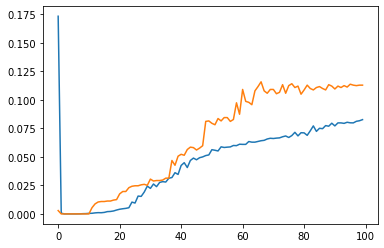

In [146]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])

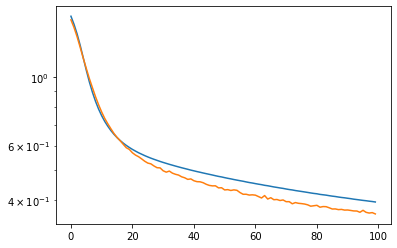

In [147]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')

In [148]:
y_pred = CNN.predict(X_test)

75/75 [==============================] - 0s 2ms/step


In [149]:
y_pred

array([[2.5674477e-01, 5.2586882e-03, 4.4068470e-04, 1.1462230e-03,
        7.3640966e-01],
       [2.1022229e-01, 1.1684810e-03, 7.8367984e-01, 4.8975949e-03,
        3.1735657e-05],
       [2.1615362e-02, 9.6219981e-01, 1.6178858e-02, 5.5766498e-07,
        5.3607491e-06],
       ...,
       [1.4737156e-01, 7.8004890e-04, 8.4863210e-01, 3.1904138e-03,
        2.5917134e-05],
       [4.8147932e-01, 1.1610509e-02, 6.8113292e-03, 2.1363513e-01,
        2.8646365e-01],
       [2.2719409e-01, 8.9131622e-04, 7.6493692e-01, 6.9279871e-03,
        4.9726943e-05]], dtype=float32)

In [150]:
y_pred= np.argmax(y_pred, axis=1)

In [151]:
y_pred

array([4, 2, 1, ..., 2, 0, 2])

In [152]:
y_pred[0]

4

In [153]:
df = pd.DataFrame({
    'y_test': y_test.ravel().astype(int).tolist(),
    'y_pred': y_pred.ravel().astype(int).tolist(),
})

In [154]:
pd.crosstab(df['y_test'], df['y_pred'])

y_pred,0,1,2,3,4
y_test,,,,,
0,272,24,8,66,107
1,18,441,18,0,0
2,0,0,477,0,0
3,0,0,0,477,0
4,0,0,0,0,477


In [49]:
# model.save('model.h5')

In [52]:
CNN.save('model_f_s_d_o_90_funcional.h5')